# Fallback - Insert Retention Scores MLB-Rays
* StellarAlgo Data Science
* Ryan Kazmerik, Grant Donst
* Sept 29, 2022

In [19]:
import boto3
import getpass
import pyodbc
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from datetime import datetime
from pytz import timezone
from pycaret.classification import *
from shared_utilities import helpers

In [20]:
if not boto3.DEFAULT_SESSION:
    ! aws sso login --profile Stellaralgo-DataScienceAdmin
    session = boto3.setup_default_session(profile_name='Stellaralgo-DataScienceAdmin')

In [21]:
LKUPCLIENTID = "45"
DBNAME = "stlrrays"
ENV = "prod-app"
SCORINGYEAR = 2022

In [22]:
df = helpers.get_retention_dataset(
    cluster = "prod-app",
    database = DBNAME,
    lkupclientid = LKUPCLIENTID,
    start_year = 2010,
    end_year = 2022
)

df.shape

Authorized as AROASQ4JELIXYLYV6P4UV:gdonst@stellaralgo.com


(0, 24)

In [5]:
df.year.value_counts()

Series([], Name: year, dtype: int64)

In [6]:
df.head()

,lkupclientid,clientcode,dimcustomermasterid,year,productgrouping,totalspent,recentdate,attendancepercent,renewedbeforedays,source_tenure,tenure,disttovenue,recency,missed_games_1,missed_games_2,missed_games_over_2,forward_records,opentosendratio,clicktosendratio,clicktoopenratio,gender,phonecall,inperson_contact,isnextyear_buyer


### We should specify the features used in our model:

In [7]:
# choose the features for the stellar base retention model
features = [
    "isnextyear_buyer",
    "recentdate",
    "clientcode",
	"dimcustomermasterid",
	"lkupclientid",
	"productgrouping",
	"year",
	"attendancepercent",
    "clicktoopenratio",
    "clicktosendratio",
    "disttovenue",
    "inperson_contact",
    "missed_games_1",
    "missed_games_2",
    "missed_games_over_2",
    "opentosendratio",
    "phonecall",
    "recency",
    "renewedbeforedays",
    "source_tenure",
    "totalspent"
]

# copy your main dataframe
df_dataset = df

# choose the features & train year & test year
df_dataset = df_dataset[features]
df_dataset["year"] = pd.to_numeric(df_dataset["year"])
df_dataset = df_dataset.loc[df_dataset["year"] < SCORINGYEAR]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (0, 21)
Unseen Data For Predictions: (0, 21)



In [8]:
print(df_dataset.year.value_counts())

Series([], Name: year, dtype: int64)


### Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [9]:
setup(
    data= df_train, 
    target="isnextyear_buyer", 
    train_size = 0.85,
    data_split_shuffle=True,
    date_features=[
        "recentdate"
    ],
    ignore_features=[
        "clientcode",
		"dimcustomermasterid",
		"lkupclientid",
		"productgrouping",
		"year"
    ],
    silent=True,
    verbose=False,
    numeric_features=[
        "attendancepercent",
        "clicktoopenratio",
        "clicktosendratio",
        "disttovenue",
        "inperson_contact",
        "missed_games_1",
        "missed_games_2",
        "missed_games_over_2",
        "opentosendratio",
        "phonecall",
        "recency",
        "renewedbeforedays",
        "tenure",
        "totalspent"
    ]
);

ValueError: data passed must be a positive dataframe

### The evaluation output prints a score grid that shows average Accuracy, AUC, Recall, Precision, F1 and Kappa accross the folds (10 by default) along with training time:

In [ ]:
model_matrix = compare_models(
    fold= 10,
    include= ["gbc","lightgbm","lr","rf","xgboost"],
    n_select=5,
    probability_threshold= 0.75
)
results = pull()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.7116,0.7954,0.6857,0.8673,0.7656,0.4038,0.4232,1.1220
xgboost,Extreme Gradient Boosting,0.7065,0.7840,0.6902,0.8552,0.7637,0.3877,0.4038,0.1560
lightgbm,Light Gradient Boosting Machine,0.7051,0.7936,0.6750,0.8668,0.7589,0.3941,0.4150,0.1860
rf,Random Forest Classifier,0.6937,0.7833,0.6626,0.8600,0.7483,0.3733,0.3946,0.0930
lr,Logistic Regression,0.6790,0.7426,0.6437,0.8536,0.7336,0.3489,0.3716,0.2740


In [ ]:
models = []
for idx, m in enumerate(model_matrix):
    
    model = create_model(m)
    final_model = finalize_model(model)
    
    models.append({
        "name": str(results.iloc[idx]["Model"]),
        "model": final_model
    })

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6701,0.7310,0.6194,0.8616,0.7207,0.3431,0.3717
1,0.6786,0.7597,0.6269,0.8690,0.7283,0.3593,0.3887
2,0.6769,0.7532,0.6468,0.8469,0.7334,0.3416,0.3620
3,0.6872,0.7580,0.6542,0.8567,0.7419,0.3625,0.3842
4,0.6667,0.7523,0.6119,0.8632,0.7162,0.3397,0.3699
5,0.7128,0.7516,0.6841,0.8703,0.7660,0.4078,0.4280
6,0.6786,0.7373,0.6294,0.8664,0.7291,0.3577,0.3860
7,0.6832,0.7327,0.6667,0.8401,0.7434,0.3436,0.3595
8,0.6815,0.7422,0.6592,0.8439,0.7402,0.3444,0.3623


/opt/miniconda3/envs/stellar/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/miniconda3/envs/stellar/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

### Let's load in our 2021 season data and get retention scores using the model:

In [10]:
df_inference = df.loc[df["year"] >= SCORINGYEAR]
df_inference = df_inference.fillna(0)
df_inference = df_inference[features]

df_inference.shape



(0, 21)

In [13]:
predictions = []
for idx, final_m in enumerate(models):
    
    df_predictions = (predict_model(final_m['model'], data=df_inference, raw_score=True))
    df_predictions = df_predictions[df_predictions["Score_1"] >= 0.025]
    final_m["predictions"] = df_predictions

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.7220,0,0.0000,0.0000,0.0000,0.0000,0.0000


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.6125,0,0.0000,0.0000,0.0000,0.0000,0.0000


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.6848,0,0.0000,0.0000,0.0000,0.0000,0.0000


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.7448,0,0.0000,0.0000,0.0000,0.0000,0.0000


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.6459,0,0.0000,0.0000,0.0000,0.0000,0.0000


### We can create some histograms to visualize each model distribution:

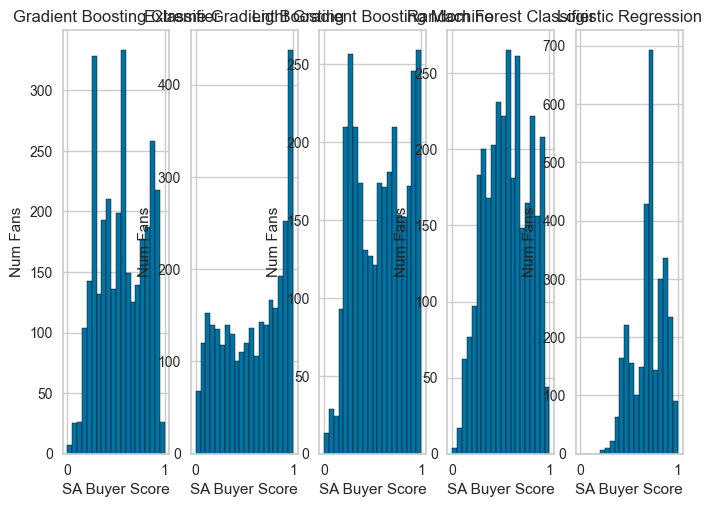

In [14]:
for idx, model in enumerate(models):
    
    plt.subplot(1, 5, idx+1)
    plt.title(model["name"])
    plt.ylabel("Num Fans")
    plt.xlabel("SA Buyer Score")
    plt.hist(model["predictions"]["Score_1"], bins=20, edgecolor="black", range=(0,1))
                            
plt.rcParams["figure.figsize"] = (25,4)
plt.show()

### We can also see how many purchases there are in each range of scores:

In [15]:
for idx, model in enumerate(models):
    print(models[idx]["predictions"]["Label"].value_counts())


0    2249
1     866
Name: Label, dtype: int64
0    1858
1    1207
Name: Label, dtype: int64
0    2125
1     982
Name: Label, dtype: int64
0    2319
1     795
Name: Label, dtype: int64
0    2011
1    1103
Name: Label, dtype: int64


### Select the model you would like to use for updating scores:

In [16]:
selected_model = "Light Gradient Boosting Machine"

for model in models:
    if model["name"] == selected_model:
        df_scores = model["predictions"]
                                 
df_scores.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3107 entries, 1 to 11200
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   isnextyear_buyer     3107 non-null   int64         
 1   recentdate           3107 non-null   datetime64[ns]
 2   clientcode           3107 non-null   object        
 3   dimcustomermasterid  3107 non-null   int64         
 4   lkupclientid         3107 non-null   int64         
 5   productgrouping      3107 non-null   object        
 6   year                 3107 non-null   int64         
 7   attendancepercent    3107 non-null   float64       
 8   clicktoopenratio     3107 non-null   object        
 9   clicktosendratio     3107 non-null   object        
 10  disttovenue          3107 non-null   float64       
 11  inperson_contact     3107 non-null   int64         
 12  missed_games_1       3107 non-null   object        
 13  missed_games_2       3107 non-nu

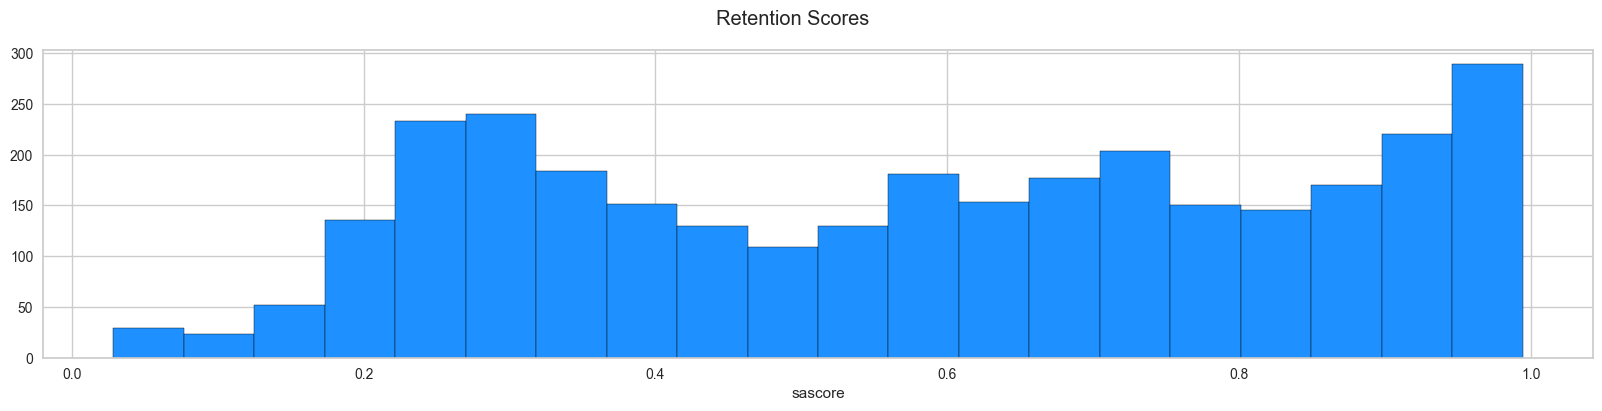

In [18]:
fig, ax1 = plt.subplots(1)
fig.suptitle('Retention Scores')
ax1.hist(df_scores['Score_1'], bins=20, edgecolor='black', color='dodgerblue')
ax1.set_xlabel('sascore')

fig.figure.set_figwidth(20)

### Optionally we can push these scores into QA so that we can see what the new scoring looks like in the CDP:

In [17]:
CONN = helpers.get_redshift_connection(ENV, DBNAME)

Authorized as AROASQ4JELIXYLYV6P4UV:gdonst@stellaralgo.com


### Insert the scores into the customerretentionscores table in RedShift:

In [28]:
cur = CONN.cursor()

batch_size = 1000
df_predictions_list = [
    df_predictions[i:i + batch_size]
    for i in range(0, df_predictions.shape[0], batch_size)
]

print(f"INSERTING {len(df_predictions)} NEW RETENTION SCORES TO DATABASE: {DBNAME} ({LKUPCLIENTID})")

fields = f"""
INSERT INTO {DBNAME}.dw.customerretentionscores (
    attendancePercentage,
    dimcustomermasterid,
    scoredate,
    lkupclientid,
    mostrecentattendance,
    product,
    sascore,
    seasonyear,
    tenuredays
) VALUES """


for i, df_prediction_batch in enumerate(df_predictions_list):

    values_list = []
    for index, row in (df_prediction_batch.iterrows()):
        
        #Hard coding score date to re-score historical dates
        values = f"""
            (
                {str(row.attendancepercent)},
                {str(row.dimcustomermasterid)},
                '2022-10-05',
                {str(row.lkupclientid)},
                '{str(row.recentdate)}',
                '{str(row.productgrouping)}',
                {str(round((row.Score_1*100),4))},
                {str(row.year)},
                {str(row.source_tenure)}
            )"""

        values_list.append(values)

    insert_statement = fields + ",".join(values_list)+";"

    cur.execute(insert_statement)
    CONN.commit()

    count = cur.rowcount
        
    print(f" > INSERTED BATCH {i+1} : ROWS {i*batch_size + 1} - {i*batch_size + len(values_list)}")

print("RETENTION SCORE INSERTS COMPLETED")

INSERTING 3114 NEW RETENTION SCORES TO DATABASE: stlrrays (45)
 > INSERTED BATCH 1 : ROWS 1 - 1000
 > INSERTED BATCH 2 : ROWS 1001 - 2000
 > INSERTED BATCH 3 : ROWS 2001 - 3000
 > INSERTED BATCH 4 : ROWS 3001 - 3114
RETENTION SCORE INSERTS COMPLETED
